In [13]:
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### import data

### Recent K commits 

In [14]:
import os
import pandas as pd

def process_commit_history(csv_file, current_time="2023-11-1", k=30):
    df = pd.read_csv(csv_file)
    df = df.dropna(subset=['date'])
    if df.empty:
        return None
    
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    
    # Filter only dates up to and including November 1, 2023
    cut_off_date = '2023-11-1'
    df = df[df['date'] <= pd.to_datetime(cut_off_date)]
    
    # Check again if DataFrame is empty after filtering by date
    if df.empty:
        return None
    
    df['timestamp'] = df['date'].astype('datetime64[s]')
    df = df.sort_values(by=['timestamp'], ascending=True)
    
        # most recent k commits
    if len(df) > k:
        df = df.iloc[-k:]
    
    df['interval'] = df['timestamp'].diff().dt.total_seconds()
    
    # Ensure there's at least one row before proceeding
    if not df.empty:
        df['interval'] = df['timestamp'].diff().dt.total_seconds()
        
        # Calculate the mean and standard deviation of commit intervals
        mean_interval = df['interval'].mean()
        sd_interval = df['interval'].std()
        
        Z = df['interval'].max()
        percentile_95 = df['interval'].dropna().quantile(0.95)
        T = pd.to_datetime(current_time)
        T_X_n = (T - df['timestamp'].iloc[-1]).total_seconds()
        time_since_last_commit_days = T_X_n / (60 * 60 * 24)
            
        classification = "unknown"
        if T_X_n > Z:
            # Reclassify as "alive" if within a certain SD from the mean
            if abs(T_X_n - mean_interval) < sd_interval:
                classification = "alive"
            else:
                classification = "dead"
        elif T_X_n < percentile_95:
            classification = "alive"
            
        mean_interval = mean_interval / (60 * 60 * 24)
        
        repo_name = os.path.basename(csv_file).split('.')[0]
        return {
            'Repo': repo_name,
            'Z': Z,
            'T_X_n': T_X_n,
            'Percentile_95': percentile_95,
            'MeanInterval(days)': mean_interval,
            'SDInterval': sd_interval,
            'Classification': classification,
            'TimeSinceLastCommit(days)': time_since_last_commit_days
        }
    else:
        return None
    
#folder_path = '/Users/ethan/Documents/Data science/MQP/main_repo_df/Data/CommitData' 
folder_path = '../../Data/CommitData'   
results_list = []  

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        csv_path = os.path.join(folder_path, file_name)
        result = process_commit_history(csv_path)
        if result:  # Only add if result is not None
            results_list.append(result)

In [15]:
# Use pd.concat to create a DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_list)

In [16]:
results_df.head(1)

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,68899153.0,989884.8,1.588616,360444.837056,dead,797.4439


In [17]:
results_df['TimeSinceLastCommit(days)'].describe()

count    1751.000000
mean      696.636028
std       916.191590
min         0.000359
25%        20.145093
50%       242.709375
75%      1125.409259
max      4959.900463
Name: TimeSinceLastCommit(days), dtype: float64

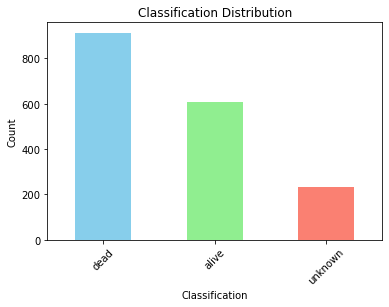

In [18]:
import matplotlib.pyplot as plt

classification_counts = results_df['Classification'].value_counts()
classification_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Classification Distribution')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Dead repos 

In [19]:
dead_repos_df = results_df[results_df['Classification'] == 'dead']
dead_repos_df.head(10)

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,68899153.0,989884.80,1.588616,3.604448e+05,dead,797.443900
2,C_1Danish-00_CompressorQueue,31220268.0,32941934.0,19001707.50,41.994261,9.370872e+06,dead,381.272384
3,C_2d-inc_developer_quest,6848421.0,122169888.0,6099397.60,7.840104,1.944424e+06,dead,1414.003333
5,C_78778443_QingScan,7278693.0,12067368.0,6344818.20,9.588466,2.045000e+06,dead,139.668611
7,C_9magnets_iOS-Developer-and-Designer-Intervie...,52066745.0,202473979.0,11257996.40,30.371325,9.972051e+06,dead,2343.448831
9,C_AbhishekChourasiya_Leetcode-Questions,356.0,123501401.0,356.00,0.004120,NaN,dead,1429.414363
10,C_abuanwar072_Quiz-App-Flutter,28052746.0,51827304.0,22938332.75,68.840289,1.124620e+07,dead,599.853056
11,C_academind_node-restful-api-tutorial,126883.0,186837657.0,120851.95,0.770515,8.529193e+04,dead,2162.472882
12,C_acmerobotics_road-runner-quickstart,495882.0,873624.0,446981.20,1.811179,1.508084e+05,dead,10.111389
14,C_AdaGold_stacks-queues,28410344.0,49016485.0,15707249.00,32.585365,6.825955e+06,dead,567.320428


In [20]:
sorted_dead_repos_df = dead_repos_df.sort_values(by='TimeSinceLastCommit(days)')
sorted_dead_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
1618,C_VelezReyes_first-quiz,46500.0,89062.0,40379.2,0.140616,1.697491e+04,dead,1.030810
281,C_DarkWinzo_Queen-AI,69544.0,209926.0,37855.6,0.063135,1.595822e+04,dead,2.429699
1350,C_robbyrussell_oh-my-zsh,234860.0,288675.0,220352.4,0.560391,6.884211e+04,dead,3.341146
590,C_iluwatar_java-design-patterns,257531.0,314299.0,113664.4,0.193370,5.447513e+04,dead,3.637720
1296,C_ra3xdh_qucs_s,91377.0,320399.0,85529.4,0.275808,3.036491e+04,dead,3.708322
...,...,...,...,...,...,...,...,...
1138,C_punkave_phpQuery,364.0,376822234.0,364.0,0.004213,NaN,dead,4361.368449
875,C_lorensiuswlt_NewQuickAction3D,7033736.0,380068774.0,5798779.8,18.357984,3.067312e+06,dead,4398.944144
570,C_huacnlee_quora,1575684.0,380569967.0,800899.2,1.889645,3.499387e+05,dead,4404.744988
1112,C_placemarker_jQuery-MD5,7546712.0,390821102.0,5972567.2,19.857190,2.504764e+06,dead,4523.392384


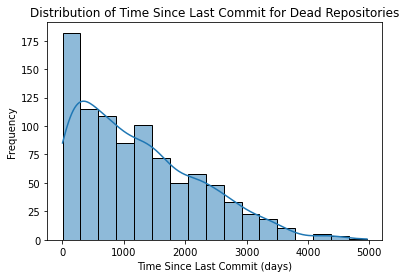

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(dead_repos_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()


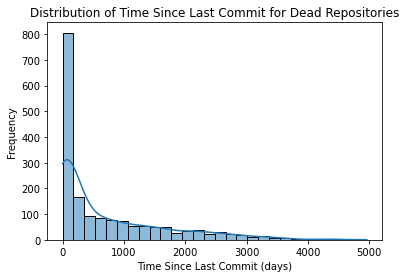

In [22]:
# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(results_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

#### Alive repos 

In [23]:
alive_repos_df = results_df[results_df['Classification'] == 'alive']
alive_repos_df.head(10)


,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
1,C_0xAX_linux-insides,9252379.0,5226272.0,7554093.6,13.694319,2.589807e+06,alive,60.489259
4,C_350306878_Kuai-Shua-Questions,64032394.0,4638526.0,39589406.6,59.179903,1.511107e+07,alive,53.686644
8,C_aamirafridi_jQuery,64920542.0,25886232.0,38042486.6,64.752743,1.575285e+07,alive,299.609167
27,C_airbnb_lottie-android,4840517.0,157247.0,2112091.0,5.897907,1.027028e+06,alive,1.819988
29,C_airbus-seclab_qemu_blog,24165616.0,13280964.0,21690479.7,51.195907,8.593245e+06,alive,153.714861
30,C_airyland_vux,25317099.0,11114467.0,13818460.2,25.340280,5.623290e+06,alive,128.639664
33,C_akullpp_awesome-java,8377543.0,303519.0,6622214.0,9.345566,2.219838e+06,alive,3.512951
34,C_Alamofire_Alamofire,2999427.0,447125.0,2151970.6,5.904027,8.099443e+05,alive,5.175058
35,C_alex-spataru_QSimpleUpdater,22821404.0,1578615.0,19527508.8,56.117694,6.551253e+06,alive,18.271007
36,C_alexa-samples_skill-sample-nodejs-quiz-game,82848861.0,17023593.0,19585149.2,57.623844,1.586120e+07,alive,197.032326


In [24]:
sorted_alive_repos_df = alive_repos_df.sort_values(by='TimeSinceLastCommit(days)', ascending=False)
sorted_alive_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
196,C_chentao0707_QrCodeScan,193643383.0,90865192.0,1.096517e+08,241.074126,6.076016e+07,alive,1051.680463
1593,C_udacity_ud843-QuakeReport,182957271.0,53868559.0,1.829573e+08,2117.561007,NaN,alive,623.478692
1511,C_ta-data-lis_lab-mysql-first-queries,82269216.0,50314358.0,6.170421e+07,158.716489,3.358550e+07,alive,582.342106
1579,C_tvvocold_How-To-Ask-Questions-The-Smart-Way,154258970.0,49141981.0,1.367203e+08,516.587500,6.758521e+07,alive,568.772928
1564,C_tomnomnom_qsreplace,82187479.0,42781581.0,7.026392e+07,245.615961,4.066405e+07,alive,495.157188
...,...,...,...,...,...,...,...,...
1252,C_QuestPDF_QuestPDF,894255.0,2095.0,5.638520e+05,1.559086,2.191632e+05,alive,0.024248
1311,C_react-querybuilder_react-querybuilder,233019.0,2023.0,9.099880e+04,0.237116,4.806723e+04,alive,0.023414
189,C_certbot_certbot,398218.0,1904.0,2.654134e+05,0.737688,9.901881e+04,alive,0.022037
1259,C_quickemu-project_quickemu,261557.0,807.0,2.090244e+05,0.654747,7.293609e+04,alive,0.009340


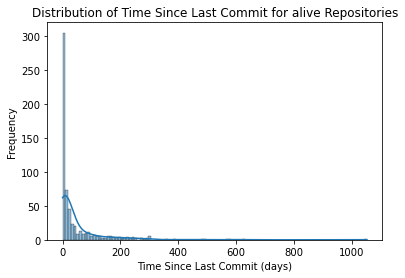

In [25]:
# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(alive_repos_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for alive Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

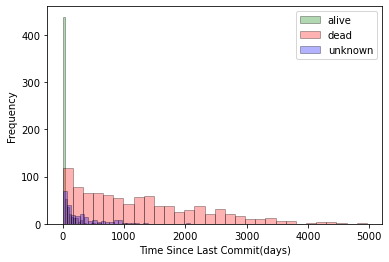

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df

# Plotting
fig, ax = plt.subplots()
colors = {'alive': 'green', 'dead': 'red', 'unknown': 'blue'}  # Example classifications
for classification, color in colors.items():
    data = results_df[results_df['Classification'] == classification]['TimeSinceLastCommit(days)']
    ax.hist(data, bins=30, alpha=0.3, label=classification, color=color, edgecolor='black')

ax.set_xlabel('Time Since Last Commit(days)')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


#### merge datasets

In [27]:
graph_data=pd.read_csv('../data/ml_data/graph_data_stats.csv', sep=",",index_col=0)
graph_data.drop('index', axis=1, inplace=True)
graph_data.head(1)

,owner,repo,stars,dateCreated,datePushed,numCommits,openIssues,closedIssues,totalIssues,totalAdditions,...,Fun Rt,nloc Rt,Halstead Volume,Maintainability Index,open_close_ratio,daysSinceLastPush,repoAgeDays,commitFrequency,closedIssueRatio,openIssueRatio
0,facebook,react,216019,2013-05-24 16:15:54,2023-12-08 00:51:20,16117,1557,25219,26776,2734078.0,...,0.01,0.06,1831.576017,57.03145,0.061737,0,3849,0.238816,0.941816,0.058147
